In [14]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

trainset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


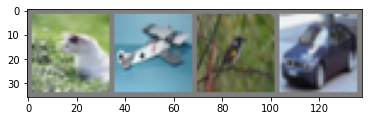

  catplane bird  car


In [15]:
import matplotlib.pyplot as plt
import numpy as np

# 展示图片
def imshow(img):
    img = img/2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 随机获得一些图片
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

print(''.join('%5s' % classes[labels[j]] for j in range(4)))

In [16]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)  # https://blog.csdn.net/weixin_38481963/article/details/109962715
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [17]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()   # 分类交叉熵做损失函数
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # SGD 做优化器

In [18]:
for epoch in range(2):  # 在数据集上多次循环
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 获取输入
        inputs, labels = data
        
        # 清零梯度
        optimizer.zero_grad()
        
        # 前向传播、反向传播、优化
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # 输出统计数据
        running_loss += loss.item()
        if i%2000 == 1999:  # 分区打印，每个小区是 2000 个数据
            print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.191
[2,  2000] loss: 1.742
Finished Training


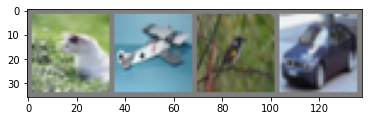

planehorsetrucktruck


In [19]:
imshow(torchvision.utils.make_grid(images))

print(''.join('%5s' % classes[labels[j]] for j in range(4)))

In [20]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:   bird plane  deer   car


In [21]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 43 %


In [24]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
     print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 51 %
Accuracy of   car : 75 %
Accuracy of  bird : 18 %
Accuracy of   cat : 35 %
Accuracy of  deer : 43 %
Accuracy of   dog : 37 %
Accuracy of  frog : 49 %
Accuracy of horse : 46 %
Accuracy of  ship : 49 %
Accuracy of truck : 31 %


In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(device)

cuda:0


In [26]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [27]:
inputs, labels = inputs.to(device), labels.to(device)